In [2]:
import os
import sys
sys.path.append('/scratch/programming/preprocessing-pipeline/src')
import numpy as np
import shutil
from skimage import io
from tqdm import tqdm
from lib.utilities_cvat_neuroglancer import mask_to_shell
from lib.sqlcontroller import SqlController
from lib.file_location import FileLocationManager
from lib.utilities_process import test_dir, SCALING_FACTOR

In [4]:
'''
Gets some info from the database used to create the numpy volume from
the masks. It then turns that numpy volume into a neuroglancer precomputed
mesh
:param animal:
:param DEBUG:
'''
animal = 'DK55'
sqlController = SqlController(animal)
fileLocationManager = FileLocationManager(animal)
INPUT = fileLocationManager.aligned_rotated_and_padded_thumbnail_mask
error = test_dir(animal, INPUT, downsample=True, same_size=True)
if len(error) > 0:
    print(error)
    sys.exit()

OUTPUT_DIR = os.path.join(fileLocationManager.neuroglancer_data, 'shell')
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

files = sorted(os.listdir(INPUT))
len_files = len(files)
midpoint = len_files // 2
volume = []
for file in tqdm(files):
    tif = io.imread(os.path.join(INPUT, file))
    tif = (tif>125)*255
    tif = mask_to_shell(tif)
    volume.append(tif)
volume = np.array(volume).astype('uint8')
volume = np.swapaxes(volume, 0, 2)
volume = (volume!=0).astype('uint8')
ids = np.unique(volume)
ids = [(i,i) for i in ids]
resolution = sqlController.scan_run.resolution
resolution = int(resolution * 1000 / SCALING_FACTOR)

100%|██████████| 485/485 [00:56<00:00,  8.65it/s]


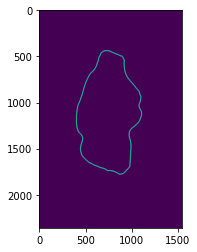

In [6]:
import matplotlib.pyplot as plt
plt.imshow(volume[:,:,181])
plt.show()

In [12]:
x,y,z = volume.shape

In [14]:
import plotly.graph_objects as go
import numpy as np
X, Y, Z = np.mgrid[0:x, 0:y, 0:z]
values = np.sin(X*Y*Z) / (X*Y*Z)

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=volume.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.show()

<ipython-input-14-e6ac56be0161>:4: RuntimeWarning:

invalid value encountered in true_divide



In [13]:
X, Y, Z = np.mgrid[0:x, 0:y, 0:z]
X

array([[[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]],

       [[   1,    1,    1, ...,    1,    1,    1],
        [   1,    1,    1, ...,    1,    1,    1],
        [   1,    1,    1, ...,    1,    1,    1],
        ...,
        [   1,    1,    1, ...,    1,    1,    1],
        [   1,    1,    1, ...,    1,    1,    1],
        [   1,    1,    1, ...,    1,    1,    1]],

       [[   2,    2,    2, ...,    2,    2,    2],
        [   2,    2,    2, ...,    2,    2,    2],
        [   2,    2,    2, ...,    2,    2,    2],
        ...,
        [   2,    2,    2, ...,    2,    2,    2],
        [   2,    2,    2, ...,    2,    2,    2],
        [   2,    2,    2, ...,    2,    2,    2]],

       ...,

       [[2356, 2356, 235